In [56]:
!pip install sounddevice -q
!pip install ipywebrtc -q
!pip install mido python-rtmidi -q
!sudo apt-get install libportaudio2 -y -qq

In [57]:
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/My Drive/10701_MachineLearning/10-701 Project/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [58]:
import numpy as np
import librosa
import sounddevice as sd
from ipywebrtc import AudioRecorder, CameraStream
from IPython.display import Audio
import ipywidgets as widgets
from google.colab import output
import random
import math
import mido
import rtmidi

In [59]:
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm

class SimpleRNN(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers, output_size):
    super(SimpleRNN, self).__init__()
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.rnn = nn.GRU(
      input_size=input_size,
      hidden_size=hidden_size,
      num_layers=num_layers,
      batch_first=True
    )
    self.fc = nn.Linear(hidden_size, output_size)

  def forward(self, x):
    # Shape: (num_layers, batch_size, hidden_size)
    h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

    # rnn_out shape: (batch_size, window_size, hidden_size)
    rnn_out, _ = self.rnn(x, h0) # We only pass in h0

    # logits shape: (batch_size, window_size, output_size)
    logits = self.fc(rnn_out)

    return logits

INPUT_SIZE = 2
HIDDEN_SIZE = 512
NUM_LAYERS = 1
OUTPUT_SIZE = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = SimpleRNN(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, OUTPUT_SIZE).to(device)

# Load checkpoint
ckpt_path = path+"v3/checkpoints_v3/epoch_080.pt"
ckpt = torch.load(ckpt_path, map_location=device)

model.load_state_dict(ckpt["model_state"])
model.eval()
print(f"Loaded checkpoint from {ckpt_path}, acc={ckpt['acc']:.3f}")

Loaded checkpoint from /content/drive/My Drive/10701_MachineLearning/10-701 Project/v3/checkpoints_v3/epoch_080.pt, acc=0.788


In [60]:
def get_leading_sample(input_array,T_start,FILE_SAMPLING_RATE,TRAIN_SAMPLING_RATE,WINDOW_SIZE):
  t=math.floor(T_start*FILE_SAMPLING_RATE)
  if t < WINDOW_SIZE*FILE_SAMPLING_RATE:
    return(np.concat((np.zeros((WINDOW_SIZE*FILE_SAMPLING_RATE - t, 2)),input_array[:t,]),axis=0)[::math.floor(FILE_SAMPLING_RATE/TRAIN_SAMPLING_RATE),])
  else:
    return(input_array[(t-WINDOW_SIZE*FILE_SAMPLING_RATE):t,][::math.floor(FILE_SAMPLING_RATE/TRAIN_SAMPLING_RATE),])
#def get_pitch(leading_sample, velocity=63):
  #return(random.randint(32, 96))
def get_pitch(leading_sample, velocity=63, model=model):
  sample = torch.from_numpy(leading_sample.astype(np.float32))
  with torch.no_grad():
    pitches = sample[:, 0]          # (T,)
    vels    = sample[:, 1]          # (T,)
    prev_pitches = pitches[:-1]                # (T-1,)
    curr_vels    = vels[1:] / 127.0           # (T-1,)
    inputs = torch.stack([prev_pitches, curr_vels], dim=-1)  # (T-1, 2)
    inputs = inputs.unsqueeze(0).to(device)                  # (1, T-1, 2)
    logits = model(inputs)               # (1, T-1, 129)
    preds  = logits.argmax(dim=-1)[0]    # (T-1,)
    #print(preds,pitches)
    return(preds[-1].item())
def label_to_midi(idx,REST_INDEX=63,MIN_PITCH=34):
    if idx == REST_INDEX:
        return int(0)
    return idx + MIN_PITCH
def get_event(input_array,T_start,T_end,FILE_SAMPLING_RATE,TRAIN_SAMPLING_RATE,WINDOW_SIZE):
  #v=random.randint(32,96)
  leading_sample=get_leading_sample(input_array,T_start,FILE_SAMPLING_RATE,TRAIN_SAMPLING_RATE,WINDOW_SIZE)
  pitch=get_pitch(leading_sample,velocity=63)
  if pitch == leading_sample[-1,0]:
    pitch = pitch + random.choice([0,2,4,5,7,-1,-3,-5,-7])
  return(np.iinfo(np.int16).max * 0.5 * np.sin(2. * np.pi * 440 * (2**((label_to_midi(pitch) - 69) / 12)) * np.linspace(0., T_end-T_start, int((T_end-T_start) * sr))),
         np.tile([pitch,63],(math.floor(T_end*FILE_SAMPLING_RATE)-math.floor(T_start*FILE_SAMPLING_RATE),1)),
        mido.Message('note_on',
                    note=label_to_midi(pitch),
                    velocity=63,
                    time=math.floor(T_start*FILE_SAMPLING_RATE)),
        mido.Message('note_off',
                     note=label_to_midi(pitch),
                    velocity=0,
                     time=math.floor(T_end*FILE_SAMPLING_RATE)-1))

In [62]:
#Record Audio Clip
##NOTE: You may need to run this cell up-to three times to initialize recorder.
output.enable_custom_widget_manager()
camera = CameraStream(constraints={'audio': True,'video':False})
recorder = AudioRecorder(stream=camera)
recorder

AudioRecorder(audio=Audio(value=b'', format='webm'), stream=CameraStream(constraints={'audio': True, 'video': …

In [82]:
#Process Clip
with open('recording.webm', 'wb') as f:
    f.write(recorder.audio.value)
!ffmpeg -i recording.webm -ac 1 -f wav my_recording.wav -y -hide_banner -loglevel panic

#Extract Onset Events
filename = 'my_recording.wav'
y, sr = librosa.load(filename)
onset_events = np.concat((librosa.onset.onset_detect(y=y, sr=sr, units='time'), np.array([len(y)/sr])))
input_array = np.zeros((math.floor(len(y)),2))
#input_array = np.random.default_rng().integers(15,31,(math.floor(len(y)),2))*2
Y = np.zeros_like(y)

#Set Sampling Properties
WINDOW_SIZE = 10
TRAIN_SAMPLING_RATE = 10
FILE_SAMPLING_RATE = sr

#Initialize MidiFile
f = mido.MidiFile(type=1, ticks_per_beat=sr)
ff = mido.MidiTrack()
f.tracks.append(ff)
ff.append(mido.MetaMessage('set_tempo', tempo=mido.bpm2tempo(60), time=0))

#Generate Melody
for i in range(len(onset_events)-1):
  T_start=onset_events[i]
  T_end=onset_events[i+1]
  Y[int(T_start * sr):(int(T_start * sr) + int((T_end-T_start) * sr))], \
    input_array[math.floor(T_start*FILE_SAMPLING_RATE):math.floor(T_end*FILE_SAMPLING_RATE),:], \
    m1, m2 = get_event(input_array,T_start,T_end,FILE_SAMPLING_RATE,TRAIN_SAMPLING_RATE,WINDOW_SIZE)
  ff.append(m1)
  ff.append(m2)

In [79]:
#Playback (original)
Audio(y, rate=sr)

In [83]:
#Playback (melody)
Audio(Y, rate=sr)

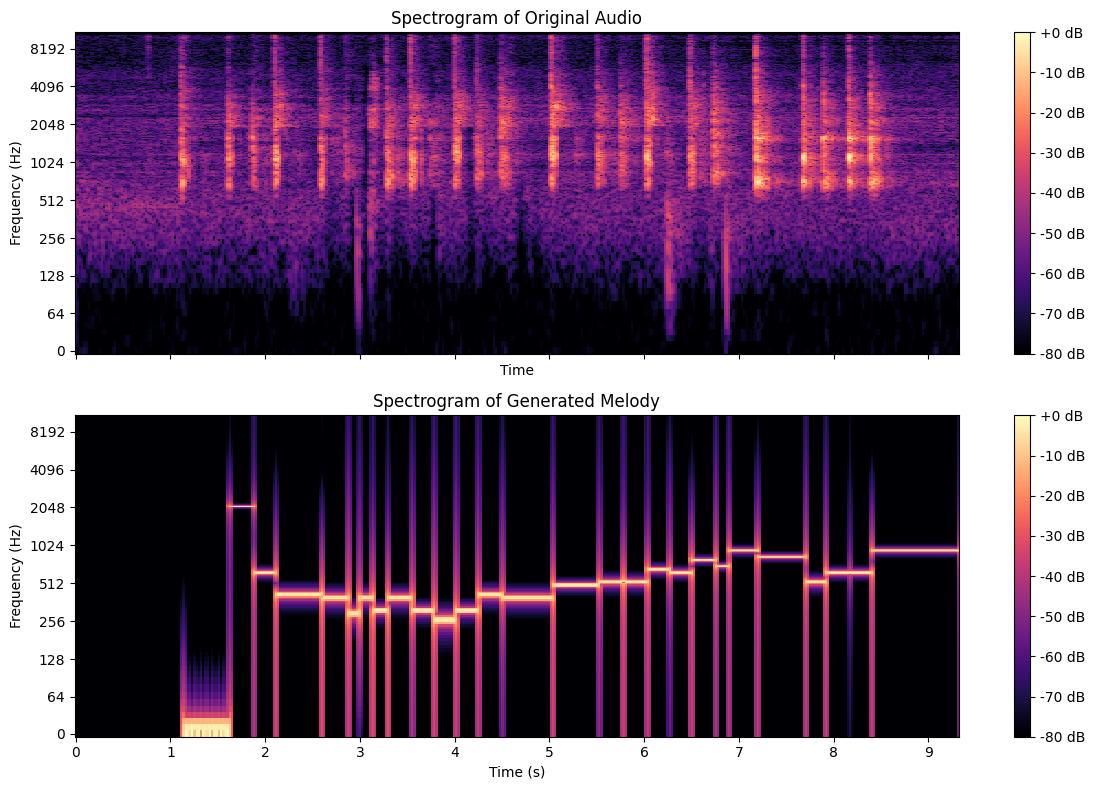

In [85]:
import matplotlib.pyplot as plt
import librosa
import librosa.display
import numpy as np

# Compute the Short-Time Fourier Transform (STFT) for the original audio (y)
D_y_spec = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)

# Compute the Short-Time Fourier Transform (STFT) for the generated melody (Y)
D_Y_spec = librosa.amplitude_to_db(np.abs(librosa.stft(Y)), ref=np.max)

# Create a figure with two subplots, stacked vertically
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(12, 8), sharex=True) # Share x-axis for consistent time alignment

# Plot 1: Spectrogram of Original Audio (y)
img_y_spec = librosa.display.specshow(D_y_spec, sr=sr, x_axis='time', y_axis='log', ax=axs[0])
fig.colorbar(img_y_spec, ax=axs[0], format='%+2.0f dB')
axs[0].set_ylabel("Frequency (Hz)")
axs[0].set_title('Spectrogram of Original Audio')

# Plot 2: Spectrogram of Generated Melody (Y)
img_Y_spec = librosa.display.specshow(D_Y_spec, sr=sr, x_axis='time', y_axis='log', ax=axs[1])
fig.colorbar(img_Y_spec, ax=axs[1], format='%+2.0f dB')
axs[1].set_ylabel("Frequency (Hz)")
axs[1].set_title('Spectrogram of Generated Melody')
axs[1].set_xlabel("Time (s)") # Only set x-label for the bottom plot

plt.tight_layout() # Adjust layout to prevent labels/titles from overlapping
plt.show()